Number of images per class:
 label
sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: count, dtype: int64


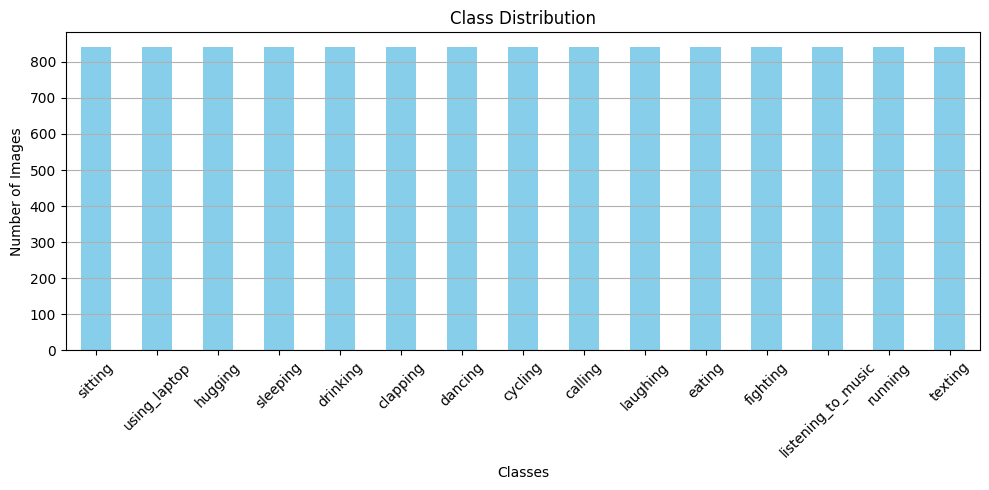


Image size distribution:
              Height         Width
count  12601.000000  12601.000000
mean     196.574399    260.379652
std       35.280124     39.917997
min       84.000000     84.000000
25%      181.000000    254.000000
50%      183.000000    275.000000
75%      194.000000    276.000000
max      318.000000    478.000000


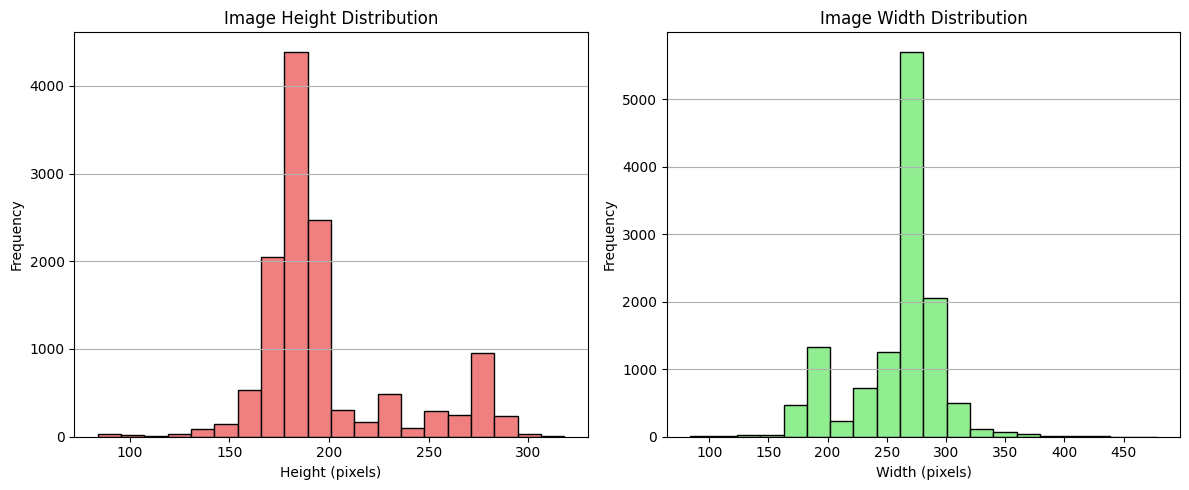

In [ ]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from collections import Counter

label_df = pd.read_csv('label.csv')

class_distribution = label_df['label'].value_counts()
print("Number of images per class:\n", class_distribution)

plt.figure(figsize=(10, 5))
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

image_folder = 'data'  
image_sizes = []

for image_file in os.listdir(image_folder):
    img = cv2.imread(os.path.join(image_folder, image_file))
    if img is not None:
        image_sizes.append(img.shape[:2])  # appends (ht,w)

image_sizes_df = pd.DataFrame(image_sizes, columns=['Height', 'Width'])
print("\nImage size distribution:\n", image_sizes_df.describe())  

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(image_sizes_df['Height'], bins=20, color='lightcoral', edgecolor='black')
plt.title('Image Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
plt.grid(axis='y')

plt.subplot(1, 2, 2)
plt.hist(image_sizes_df['Width'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Image Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.grid(axis='y')

plt.tight_layout()


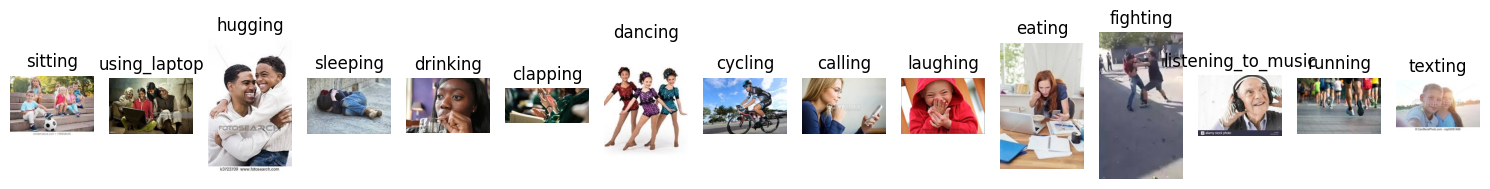

In [14]:
unique_labels = label_df['label'].unique()
num_classes = len(unique_labels)

fig, axs = plt.subplots(1, num_classes, figsize=(15, 5)) 

for idx, class_label in enumerate(unique_labels):
    sample_image_file = label_df[label_df['label'] == class_label]['filename'].sample().values[0] 
    img = cv2.imread(os.path.join(image_folder, sample_image_file))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # plot img as subplot
    axs[idx].imshow(img_rgb)
    axs[idx].set_title(f'{class_label}')
    axs[idx].axis('off')

# display
plt.tight_layout()
plt.show()


Class distribution imbalance:
 label
sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: count, dtype: int64


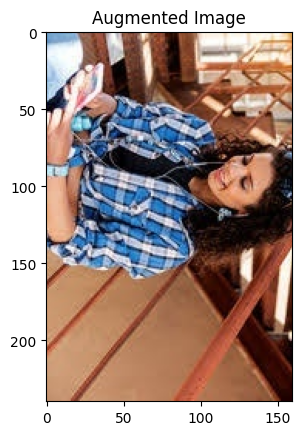

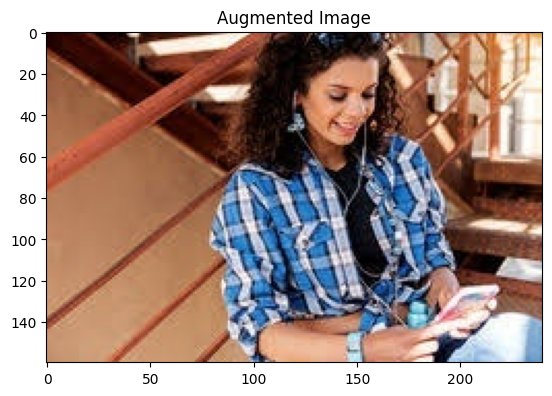

In [15]:
print("Class distribution imbalance:\n", class_distribution)

def augment_image(image):
    rotated_image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    flipped_image = cv2.flip(image, 1) 
    return [rotated_image, flipped_image]

sample_image_file = label_df['filename'][0]
image = cv2.imread(os.path.join(image_folder, sample_image_file))
augmented_images = augment_image(image)

for img in augmented_images:
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title('Augmented Image')
    plt.show()


In [1]:
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import pickle

# Feature extraction functions
def extract_color_histogram(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist) 
    return hist.flatten()

def extract_lbp_features(image):
    lbp = local_binary_pattern(image, P=8, R=1, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    hist = hist.astype("float") / hist.sum()  
    return hist

def extract_gabor_features(image):
    gabor_features = []
    for theta in range(4):  # 0, 45, 90, 135 degrees
        theta = theta / 4.0 * np.pi
        for sigma in [1, 3]:  # Standard deviations
            kernel = cv2.getGaborKernel((21, 21), sigma, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
            filtered = cv2.filter2D(image, cv2.CV_8UC3, kernel)
            gabor_features.append(np.mean(filtered))
            gabor_features.append(np.var(filtered))
    return np.array(gabor_features)

def extract_glcm_features(image):
    glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return np.array([contrast, dissimilarity, homogeneity, energy, correlation])


def extract_orb_features(image, max_features=100):
    orb = cv2.ORB_create(nfeatures=max_features)  
    keypoints, descriptors = orb.detectAndCompute(image, None)
    
    if descriptors is None:
        return np.zeros(max_features)
    elif descriptors.shape[0] < max_features:
        padded_descriptors = np.zeros((max_features, descriptors.shape[1]))
        padded_descriptors[:descriptors.shape[0], :] = descriptors
        descriptors = padded_descriptors
    return descriptors.flatten()[:max_features]

# Load labels
image_folder = 'data'
label_csv = 'label.csv'
label_df = pd.read_csv(label_csv)

# Check
if not os.path.exists('train_test_data.pkl'):
    features = []
    labels = []

    # extract ft
    for idx, row in label_df.iterrows():
        image_path = os.path.join(image_folder, row['filename'])
        image = cv2.imread(image_path)
        image_resized = cv2.resize(image, (64, 128))
        gray_image = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

        hog_features = hog(gray_image, pixels_per_cell=(24,24), cells_per_block=(1,1), visualize=False)
        hog_features = hog_features.flatten()
        color_hist = extract_color_histogram(image_resized)
        lbp_features = extract_lbp_features(gray_image)
        gabor_features = extract_gabor_features(gray_image)
        glcm_features = extract_glcm_features(gray_image)
        orb_features = extract_orb_features(gray_image)

        # Combine
        combined_features = np.hstack((hog_features, color_hist, lbp_features, gabor_features, glcm_features, orb_features))

        features.append(combined_features)
        labels.append(row['label'])

    X = np.array(features)
    y = np.array(labels)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Save
    with open('train_test_data.pkl', 'wb') as f:
        pickle.dump((X_train, X_test, y_train, y_test), f)

else:
    # Load
    with open('train_test_data.pkl', 'rb') as f:
        X_train, X_test, y_train, y_test = pickle.load(f)


In [2]:
import pickle
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

model = GaussianNB()
hyperparameters = {}

model.fit(X_train, y_train)

y_train_1 = model.predict(X_train)
y_pred = model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)

print(f"Test accuracy: {test_accuracy:.4f}")

def log_model_performance(filename, hyperparameters, accuracy):
    with open(filename, 'a') as file:
        file.write(f"Model: Naive Bayes\n")
        file.write(f"Hyperparameters: {hyperparameters}\n")
        file.write(f"Accuracy: {accuracy:.4f}\n\n")

log_model_performance('accuracy.txt', hyperparameters, test_accuracy)

with open('naive_bayes_model.pkl', 'wb') as file:
    pickle.dump(model, file)

Test accuracy: 0.1873


In [8]:
def log_model_performance(file_path, hyperparameters, test_accuracy):
    with open(file_path, 'a') as f: 
        f.write('Random Forest\n')
        f.write("Model Hyperparameters: \n")
        for param, value in hyperparameters.items():
            f.write(f"{param}: {value}\n")
        f.write(f"Test Accuracy: {test_accuracy:.4f}\n")
        f.write('\n')

In [36]:
model = RandomForestClassifier(random_state=42, max_depth=50, n_estimators=5000, class_weight=None, n_jobs=-1, min_samples_split=5, min_samples_leaf=5)
hyperparamters = {'random_state':42, 'max_depth':50, 'n_estimators':5000,  'n_jobs':-1, 'min_samples_split':5, 'min_samples_leaf':5}
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_train_1 = model.predict(X_train)
print(f"Training accuracy: {accuracy_score(y_train, y_train_1)}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy:.4f}")
log_model_performance('accuracy.txt', hyperparamters, accuracy)

Training accuracy: 0.9868055555555556
Random Forest Model Accuracy: 0.3575


In [37]:
model = RandomForestClassifier(random_state=42, max_depth=25, n_estimators=5000, class_weight=None, n_jobs=-1, min_samples_split=5, min_samples_leaf=2)
hyperparamters = {'random_state':42, 'max_depth':25, 'n_estimators':5000,  'n_jobs':-1, 'min_samples_split':5, 'min_samples_leaf':2}
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_train_1 = model.predict(X_train)
print(f"Training accuracy: {accuracy_score(y_train, y_train_1)}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy:.4f}")
log_model_performance('accuracy.txt', hyperparamters, accuracy)

Training accuracy: 1.0
Random Forest Model Accuracy: 0.3587


In [38]:
model = RandomForestClassifier(random_state=42, max_depth=20, n_estimators=5000, class_weight=None, n_jobs=-1, min_samples_split=5, min_samples_leaf=2)
hyperparamters = {'random_state':42, 'max_depth':20, 'n_estimators':5000,  'n_jobs':-1, 'min_samples_split':5, 'min_samples_leaf':2}

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_train_1 = model.predict(X_train)
print(f"Training accuracy: {accuracy_score(y_train, y_train_1)}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy:.4f}")
log_model_performance('accuracy.txt', hyperparamters, accuracy)

Training accuracy: 1.0
Random Forest Model Accuracy: 0.3595


In [39]:
model = RandomForestClassifier(random_state=42, max_depth=25, n_estimators=5000, class_weight=None, n_jobs=-1, min_samples_split=5, min_samples_leaf=2)
hyperparamters = {'random_state':42, 'max_depth':25, 'n_estimators':5000,  'n_jobs':-1, 'min_samples_split':5, 'min_samples_leaf':2}
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_train_1 = model.predict(X_train)
print(f"Training accuracy: {accuracy_score(y_train, y_train_1)}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy:.4f}")
log_model_performance('accuracy.txt', hyperparamters, accuracy)

Training accuracy: 1.0
Random Forest Model Accuracy: 0.3587


In [40]:
model = RandomForestClassifier(random_state=42, max_depth=25, n_estimators=5000, class_weight=None, n_jobs=-1, min_samples_split=10, min_samples_leaf=10)
hyperparamters = {'random_state':42, 'max_depth':25, 'n_estimators':5000,  'n_jobs':-1, 'min_samples_split':10, 'min_samples_leaf':10}
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_train_1 = model.predict(X_train)
print(f"Training accuracy: {accuracy_score(y_train, y_train_1)}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy:.4f}")
log_model_performance('accuracy.txt', hyperparamters, accuracy)

Training accuracy: 0.8926587301587302
Random Forest Model Accuracy: 0.3429


In [41]:
model = RandomForestClassifier(random_state=42, max_depth=16, n_estimators=10000, class_weight=None, n_jobs=-1, min_samples_split=10, min_samples_leaf=10)
hyperparamters = {'random_state':42, 'max_depth':16, 'n_estimators':10000,  'n_jobs':-1, 'min_samples_split':10, 'min_samples_leaf':10}
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_train_1 = model.predict(X_train)
print(f"Training accuracy: {accuracy_score(y_train, y_train_1)}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy:.4f}")
log_model_performance('accuracy.txt', hyperparamters, accuracy)

Training accuracy: 0.8888888888888888
Random Forest Model Accuracy: 0.3405


In [42]:
model = RandomForestClassifier(random_state=42, max_depth=16, n_estimators=10000, class_weight=None, n_jobs=-1, min_samples_split=15, min_samples_leaf=12)
hyperparamters = {'random_state':42, 'max_depth':16, 'n_estimators':10000,  'n_jobs':-1, 'min_samples_split':15, 'min_samples_leaf':12}
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_train_1 = model.predict(X_train)
print(f"Training accuracy: {accuracy_score(y_train, y_train_1)}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy:.4f}")
log_model_performance('accuracy.txt', hyperparamters, accuracy)

Training accuracy: 0.8463293650793651
Random Forest Model Accuracy: 0.3385


In [43]:
model = RandomForestClassifier(random_state=42, max_depth=20, n_estimators=10000, class_weight=None, n_jobs=-1, min_samples_split=12, min_samples_leaf=12)
hyperparamters = {'random_state':42, 'max_depth':20, 'n_estimators':10000,  'n_jobs':-1, 'min_samples_split':12, 'min_samples_leaf':12}
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_train_1 = model.predict(X_train)
print(f"Training accuracy: {accuracy_score(y_train, y_train_1)}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy:.4f}")
log_model_performance('accuracy.txt', hyperparamters, accuracy)

Training accuracy: 0.847718253968254
Random Forest Model Accuracy: 0.3409


In [44]:
model = RandomForestClassifier(random_state=42, max_depth=16, n_estimators=5000, class_weight=None, n_jobs=-1, min_samples_split=5, min_samples_leaf=2)
hyperparamters = {'random_state':42, 'max_depth':16, 'n_estimators':10000,  'n_jobs':-1, 'min_samples_split':5, 'min_samples_leaf':2}
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_train_1 = model.predict(X_train)
print(f"Training accuracy: {accuracy_score(y_train, y_train_1)}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy:.4f}")
log_model_performance('accuracy.txt', hyperparamters, accuracy)

Training accuracy: 1.0
Random Forest Model Accuracy: 0.3611


In [45]:
model = RandomForestClassifier(random_state=42, max_depth=16, n_estimators=7000, class_weight=None, n_jobs=-1, min_samples_split=5, min_samples_leaf=2)
hyperparamters = {'random_state':42, 'max_depth':16, 'n_estimators':7000,  'n_jobs':-1, 'min_samples_split':5, 'min_samples_leaf':2}
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_train_1 = model.predict(X_train)
print(f"Training accuracy: {accuracy_score(y_train, y_train_1)}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy:.4f}")
log_model_performance('accuracy.txt', hyperparamters, accuracy)

Training accuracy: 1.0
Random Forest Model Accuracy: 0.3627


In [18]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(random_state=42, max_depth=16, n_estimators=7000, 
                               class_weight=None, n_jobs=-1, min_samples_split=5, min_samples_leaf=2)

model.fit(X_train, y_train)

with open('random_forest_model_images.pkl', 'wb') as file:
    pickle.dump(model, file)

y_train_1 = model.predict(X_train)
y_pred = model.predict(X_test)

print(f"Test accuracy: {accuracy_score(y_test, y_pred):.4f}")


Test accuracy: 0.3627


In [4]:
import pickle
from sklearn.metrics import accuracy_score


with open('random_forest_model_images.pkl', 'rb') as file:
    loaded_model = pickle.load(file)


y_pred_loaded = loaded_model.predict(X_test)

# accuracy
accuracy_loaded = accuracy_score(y_test, y_pred_loaded)
print(f"Loaded Model Test Accuracy: {accuracy_loaded:.4f}")


Loaded Model Test Accuracy: 0.3627
